# Week 01 | Homework

Submission date: June 10, 2022<br>
Assignment: [here](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/01-intro/homework.md)

In [1]:
import pandas as pd # Data visualization
import seaborn as sns
import matplotlib.pyplot as plt # Onehot encoding of pickup and drop location
from sklearn.feature_extraction import DictVectorizer # Regression using LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge # Calculting the score of model
from sklearn.metrics import mean_squared_error 
# Save model
import pickle
%matplotlib inline

In [3]:
!pip install pyarrow  # For parquet file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_parquet('/content/sample_data/fhv_tripdata_2021-01.parquet')

In [5]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


## Q1. Read the data for January. How many records are there?

In [6]:
df.shape[0]

1154112

Answer: 1154112 records

## Q2. What's the average trip duration in January?

In [7]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()
# Average / Mean 19.16

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

Answer: 19.16 seconds

## Distribution of the duration variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


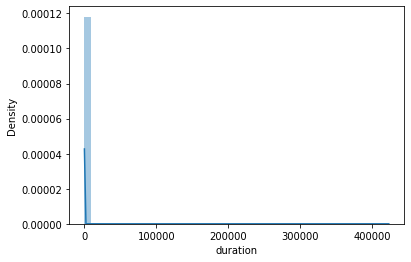

In [8]:
sns.distplot(df.duration)

## Q3. How many records did you drop?

In [9]:
pre_count = df.shape[0]
df = df[(df.duration >= 1) & (df.duration <= 60 )]
post_count = df.shape[0]
pre_count - post_count 

44286

Answer: 44286 records

## What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [10]:
# df = df.fillna(-1)
df['PUlocationID'].fillna(-1, inplace=True)
df['DOlocationID'].fillna(-1, inplace=True)

In [11]:
(df['PUlocationID'] == -1.0).sum() / post_count * 100 


83.52732770722618

Answer: 83.52%

## Q4. What's the dimensionality of this matrix? (The number of columns).

In [12]:
df = df[(df.duration >= 1) & (df.duration <= 60 )]

In [13]:
categotical = ['PUlocationID', 'DOlocationID']

In [14]:
df[categotical] = df[categotical].astype(str)

In [15]:
dv = DictVectorizer()

In [16]:
train_dicts = df[categotical].to_dict(orient='records')

In [17]:
X_train = dv.fit_transform(train_dicts)

In [18]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

Answer: 109826x525 sparse matrix 

In [19]:
target = 'duration'
y_train = df[target].values

In [20]:
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


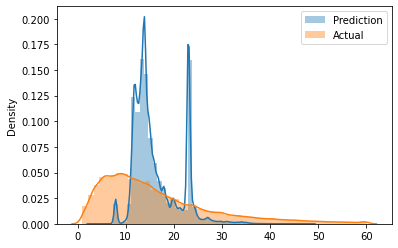

In [22]:
sns.distplot(y_pred, label= 'Prediction')
sns.distplot(y_train, label= 'Actual')
plt.legend()

In [23]:
mean_squared_error(y_train, y_pred, squared=False)
# RSME on train
# 10.528519107212968

10.528519107210744

---

## Validation on Feb dataset

In [24]:
def read_dataframe(df1):
    df1 = pd.read_parquet("/content/sample_data/fhv_tripdata_2021-02.parquet")

    df1['duration'] = df1.dropOff_datetime - df1.pickup_datetime
    df1.duration = df1.duration.apply(lambda td: td.total_seconds() / 60)

    df1 = df1[(df1.duration >= 1) & (df1.duration <= 60 )]
    
    df1['PUlocationID'].fillna(-1, inplace=True)
    df1['DOlocationID'].fillna(-1, inplace=True)

    categotical = ['PUlocationID', 'DOlocationID']
    
    df1[categotical] = df1[categotical].astype(str)
    # For One Hot encoding, values must be passed as string to be converted into numerical 
    
    return df1

In [25]:
# Training dataset   - JAN
df_train = read_dataframe('/content/sample_data/fhv_tripdata_2021-01.parquet')
# Validation dataset - FEB
df_val = read_dataframe('/content/sample_data/fhv_tripdata_2021-02.parquet')

In [26]:
# Compare length of both dataset
len(df_train), len(df_val)

(990113, 990113)

In [27]:
categotical = ['PUlocationID', 'DOlocationID']

dv = DictVectorizer()

train_dicts = df_train[categotical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categotical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)
# 11.014283222736072

10.95822844199181

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


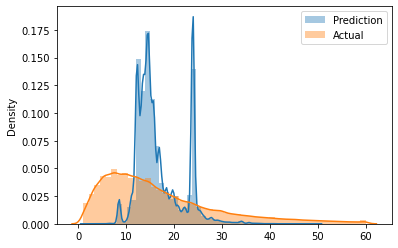

In [30]:
sns.distplot(y_pred, label= 'Prediction')
sns.distplot(y_train, label= 'Actual')
plt.legend()

## Observation

The Feb dataset has most values around the 10 min mark, however<br>
Our model predicts mostly around 15 mins and 23 mins which is approx 11 min off the actual value considering average.